# Jupyter Notebook - Projet Banklytics
## Estimation de la Valeur des Biens Immobiliers

Version mise à jour inspirée des meilleures pratiques de preprocessing et d'optimisation.

Ce notebook suit la méthodologie du projet, de l'analyse à la soumission, en intégrant un pipeline Scikit-Learn robuste et une optimisation d'hyperparamètres avec Optuna.

In [1]:
# ======================================================================
# 0. Configuration de l'Environnement
# ======================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb
import optuna

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Phase d'Idéation : Compréhension du Contexte et des Données

In [ ]:
# 1.1 Chargement des données
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print(f"Données d'entraînement chargées : {train_df.shape}")
    print(f"Données de test chargées : {test_df.shape}")
except FileNotFoundError:
    print("Erreur : Assurez-vous que les fichiers 'train.csv' et 'test.csv' sont présents.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

if not train_df.empty:
    train_ID = train_df['Id']
    test_ID = test_df['Id']
    train_df.drop('Id', axis=1, inplace=True)
    test_df.drop('Id', axis=1, inplace=True)

Données d'entraînement chargées : (1460, 81)
Données de test chargées : (1459, 80)


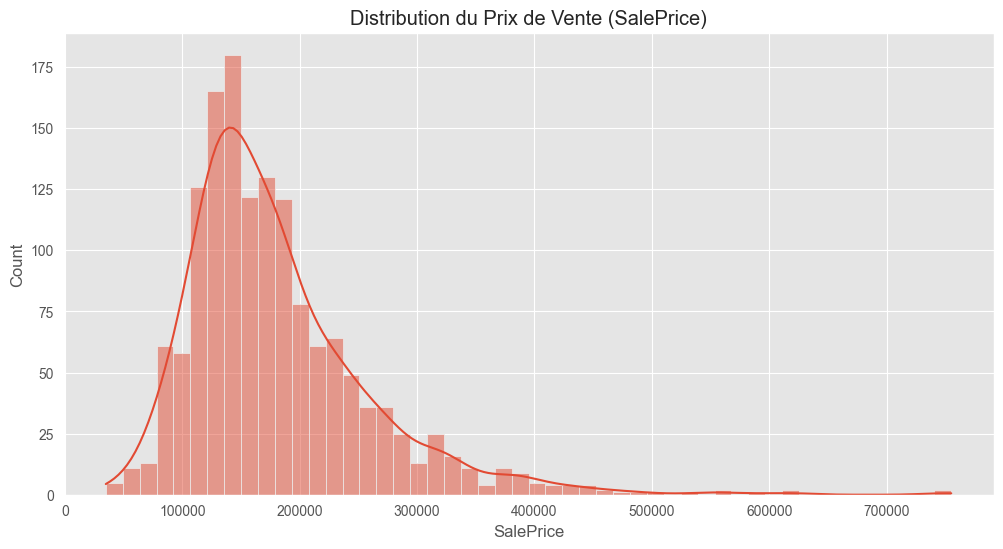

Asymétrie (Skewness) du prix de vente : 1.88
La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.


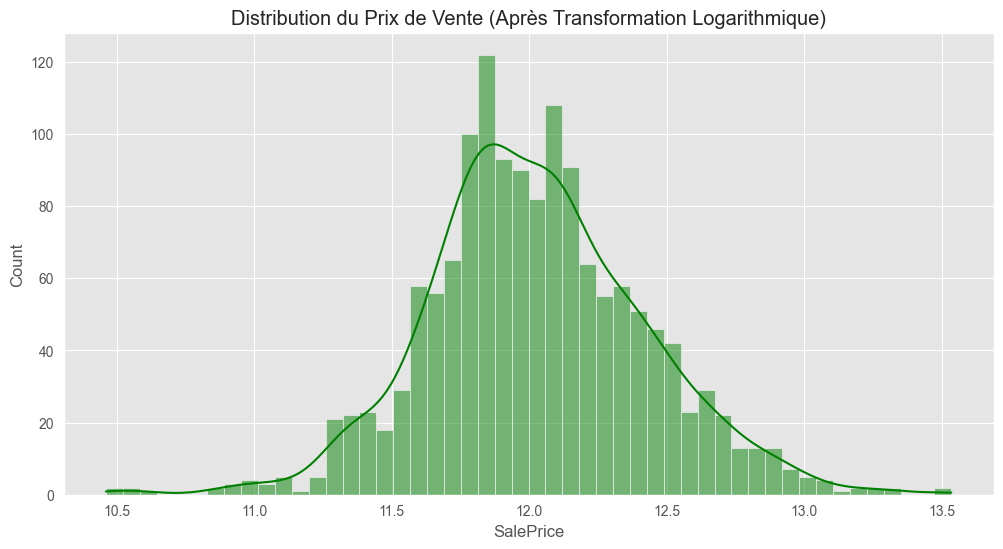

Asymétrie après transformation : 0.12


In [3]:
# 1.2 Analyse Exploratoire des Données (EDA)
if 'SalePrice' in train_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df['SalePrice'], kde=True, bins=50)
    plt.title('Distribution du Prix de Vente (SalePrice)')
    plt.show()
    print(f"Asymétrie (Skewness) du prix de vente : {train_df['SalePrice'].skew():.2f}")
    print("La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.")

    train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

    plt.figure(figsize=(12, 6))
    sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
    plt.title('Distribution du Prix de Vente (Après Transformation Logarithmique)')
    plt.show()
    print(f"Asymétrie après transformation : {train_df['SalePrice'].skew():.2f}")

Il convient maintenant de nous intéresser de plus près aux données que nous avons à disposition afin de créer nos modèles.



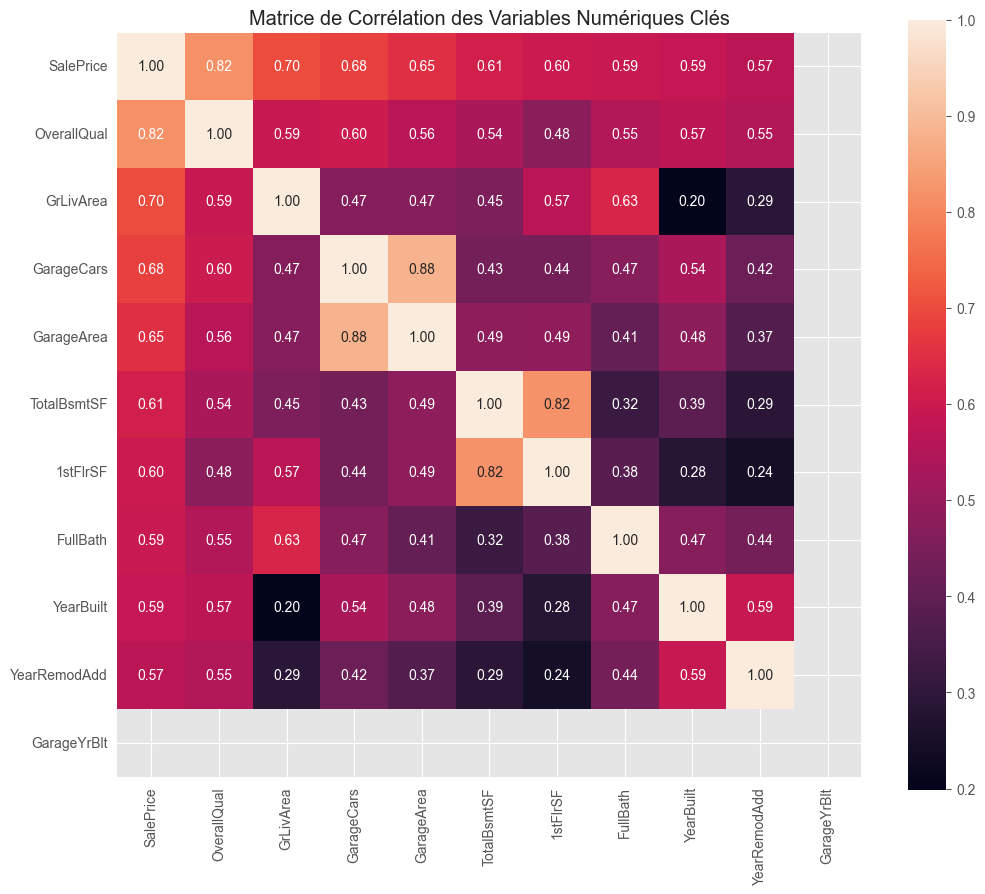

In [14]:
# Corrélation des variables
if not train_df.empty:
    numeric_features = train_df.select_dtypes(include=np.number)
    corrmat = numeric_features.corr()
    plt.figure(figsize=(12, 10))
    k = 11
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(train_df[cols].values.T)
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.title('Matrice de Corrélation des Variables Numériques Clés')
    plt.show()

## 2. Phase de Design : Ingénierie des Données et Pipeline de Modélisation

In [5]:
# Séparation des features (X) et de la cible (y)
if 'SalePrice' in train_df.columns:
    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']
    X_test = test_df.copy()

# Ingénierie des Features
all_data = pd.concat([X, X_test], axis=0)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.5].index
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat], lam)

X = all_data.iloc[:len(y)]
X_test = all_data.iloc[len(y):]

In [6]:
# Pipelines de prétraitement
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

## 3. Phase de Validation : Optimisation des Hyperparamètres avec Optuna

In [7]:
print("\n--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(full_pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print(f"\nMeilleur score RMSLE (validation croisée): {study.best_value:.5f}")
print("Meilleurs hyperparamètres trouvés:")
print(study.best_params)

optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

[I 2025-06-23 15:52:14,321] A new study created in memory with name: no-name-f9ad6234-4d98-4d93-97f7-27b7afa75810



--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---


[I 2025-06-23 15:52:19,904] Trial 0 finished with value: 0.14226424561649248 and parameters: {'n_estimators': 849, 'learning_rate': 0.027784044530401175, 'max_depth': 9, 'subsample': 0.9695833259816619, 'colsample_bytree': 0.6966911021733347, 'reg_alpha': 2.0968753535122322e-06, 'reg_lambda': 1.5234192176078989e-06}. Best is trial 0 with value: 0.14226424561649248.
[I 2025-06-23 15:52:23,315] Trial 1 finished with value: 0.12702535160579273 and parameters: {'n_estimators': 1415, 'learning_rate': 0.010359040373357546, 'max_depth': 3, 'subsample': 0.5978904360072781, 'colsample_bytree': 0.7786527231224023, 'reg_alpha': 0.00030218634410836146, 'reg_lambda': 0.015570318152254103}. Best is trial 1 with value: 0.12702535160579273.
[I 2025-06-23 15:52:32,513] Trial 2 finished with value: 0.13362225377242315 and parameters: {'n_estimators': 3339, 'learning_rate': 0.04930397509579013, 'max_depth': 7, 'subsample': 0.5560053170591033, 'colsample_bytree': 0.9248764690776133, 'reg_alpha': 1.3148103


Meilleur score RMSLE (validation croisée): 0.12303
Meilleurs hyperparamètres trouvés:
{'n_estimators': 741, 'learning_rate': 0.02984837308521732, 'max_depth': 4, 'subsample': 0.5202367794258868, 'colsample_bytree': 0.5173337109158769, 'reg_alpha': 5.019773961200677e-08, 'reg_lambda': 0.26037031584767734}


## 4. Phase de Déploiement : Entraînement final et Prédiction

In [8]:
print("\n--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---")

final_model = xgb.XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])
final_pipeline.fit(X, y)
print("Entraînement terminé.")

log_predictions = final_pipeline.predict(X_test)
final_predictions = np.expm1(log_predictions)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_predictions})
submission.to_csv('submission_optimized.csv', index=False)

print("\nFichier 'submission_optimized.csv' généré avec succès.")
print("Aperçu des prédictions :")
print(submission.head())


--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---
Entraînement terminé.

Fichier 'submission_optimized.csv' généré avec succès.
Aperçu des prédictions :
     Id      SalePrice
0  1461  127122.515625
1  1462  159254.453125
2  1463  183663.468750
3  1464  193250.406250
4  1465  185781.843750


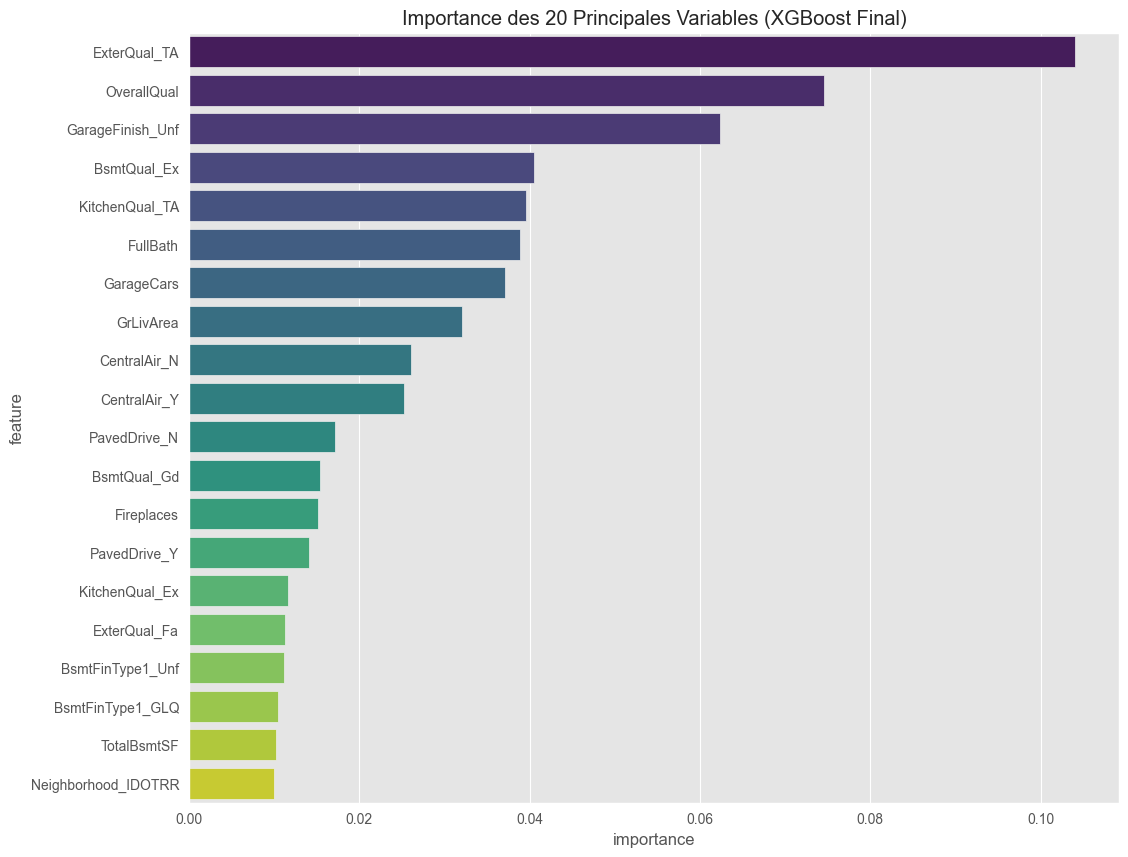

In [9]:
# 4.3 Analyse de l'Importance des Variables
ohe_feature_names = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Importance des 20 Principales Variables (XGBoost Final)')
plt.show()

## Conclusion

Ce notebook a appliqué une démarche robuste et moderne :

1. Utilisation d'un pipeline Scikit-Learn pour un prétraitement propre et reproductible.
2. Optimisation automatisée des hyperparamètres avec Optuna pour maximiser la performance.
3. Entraînement d'un modèle final performant et génération des prédictions.
4. Analyse de l'importance des variables pour une meilleure explicabilité du modèle.

Le modèle est prêt à être intégré comme outil d'aide à la décision pour les analystes de Banklytics.